
# Tren Karier Data di Indonesia — Analisis & ML untuk SmartPath

Notebook ini berisi langkah-langkah analisis data, modelling ML ringan, dan clustering untuk membantu SmartPath membuat keputusan kurikulum & career services.

**Isi:** EDA → Preprocessing → Feature Engineering → Clustering (KMeans) → Classification (RandomForest) untuk memprediksi demand level → Regression untuk growth trend.

**File data:** `data_career_trend_indonesia.csv` (sample) — ganti dengan data nyata untuk hasil lebih kuat.


In [28]:
# Imports & setup
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
import joblib
pd.options.display.max_columns = 200

# Load data
df = pd.read_csv('data_career_trend_indonesia.csv')
df.head()

,job_id,role,industry,city,avg_salary_million_idr,demand_index,experience_required_years,remote_opportunity,top_skill,growth_trend_percent
0,1,ML Engineer,E-commerce,Medan,10,91,2,0,PowerBI,21
1,2,Business Intelligence,Technology,Bandung,17,71,4,1,PowerBI,23
2,3,Data Engineer,Technology,Jakarta,30,70,4,0,R,17
3,4,Business Intelligence,Healthcare,Surabaya,26,55,4,0,Tableau,4
4,5,Business Intelligence,Telecommunication,Medan,28,50,2,1,TensorFlow,19



## EDA singkat
- Cek distribusi target dan variabel numerik.
- Buat label `demand_level` dari `demand_index`:
  - High: >=80
  - Medium: 65-79
  - Low: <65


In [29]:
# ====================
# Feature Engineering
# ====================
def demand_level(idx):
    if idx >= 80: return 'High'
    if idx >= 65: return 'Medium'
    return 'Low'

df['demand_level'] = df['demand_index'].apply(demand_level)

# Fitur baru
df['salary_per_year_exp'] = df['avg_salary_million_idr'] / (df['experience_required_years'] + 1)
df['role_industry'] = df['role'] + "_" + df['industry']

# Target transform (log)
df['growth_trend_log'] = np.log1p(df['growth_trend_percent'] - df['growth_trend_percent'].min() + 1)



## Preprocessing & Feature Engineering
- One-hot encode categorical features: role, industry, city
- Use numeric features: avg_salary_million_idr, demand_index, experience_required_years, remote_opportunity, growth_trend_percent
- For classification, target = demand_level


In [30]:
# ====================
# Select features
# ====================
features = ['role','industry','city','top_skill',
            'avg_salary_million_idr','experience_required_years',
            'remote_opportunity','demand_index',
            'salary_per_year_exp','role_industry']

target_clf = 'demand_level'
target_reg = 'growth_trend_log'

X = df[features].copy()
y_clf = df[target_clf].copy()
y_reg = df[target_reg].copy()

cat_cols = ['role','industry','city','top_skill','role_industry']
num_cols = ['avg_salary_million_idr','experience_required_years',
            'remote_opportunity','demand_index','salary_per_year_exp']

num_pipe = Pipeline([('scaler', StandardScaler())])
cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

## RandomForest Classification — Predict Demand Level (High/Medium/Low)

In [31]:
# ====================
# Classification
# ====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

clf = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

# Feature importance (approx)
X_test_trans = preprocessor.transform(X_test)
if hasattr(X_test_trans, "toarray"):
    X_test_trans = X_test_trans.toarray()

r = permutation_importance(
    clf.named_steps['rf'],
    X_test_trans,
    pd.Series(y_test).map({'Low':0,'Medium':1,'High':2}),
    n_repeats=10,
    random_state=42
)

onehot_cols = list(
    clf.named_steps['prep'].named_transformers_['cat']
    .named_steps['ohe'].get_feature_names_out(cat_cols)
)
feature_names = num_cols + onehot_cols
imp_df = pd.DataFrame({'feature': feature_names, 'importance': r.importances_mean})
print(imp_df.sort_values('importance', ascending=False).head(15))

=== Classification Report ===
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        16
         Low       1.00      1.00      1.00        14
      Medium       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion matrix:
 [[16  0  0]
 [ 0 14  0]
 [ 0  0 10]]
                                              feature  importance
0                              avg_salary_million_idr         0.0
49          role_industry_Data Engineer_Manufacturing         0.0
35  role_industry_Business Intelligence_Manufacturing         0.0
36     role_industry_Business Intelligence_Technology         0.0
37  role_industry_Business Intelligence_Telecommun...         0.0
38              role_industry_Data Analyst_E-commerce         0.0
39               role_industry_Data Analyst_Education         0.0
40   

## RandomForest Regression — Predict Growth Trend Percent

In [32]:
# ====================
# Regression
# ====================
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

reg = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42))
])

# Hyperparameter tuning
param_grid = {
    'rf__n_estimators': [200, 300, 500],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}
search = RandomizedSearchCV(
    reg, param_distributions=param_grid,
    n_iter=15, cv=5, scoring='r2', n_jobs=-1, random_state=42
)

search.fit(Xr_train, yr_train)
best_reg = search.best_estimator_

yr_pred = best_reg.predict(Xr_test)

# Inverse log transform
yr_pred_inv = np.expm1(yr_pred) + df['growth_trend_percent'].min() - 1
yr_test_inv = np.expm1(yr_test) + df['growth_trend_percent'].min() - 1

print("\n=== Regression Report (Best RF) ===")
print('RMSE:', mean_squared_error(yr_test_inv, yr_pred_inv, squared=False))
print('R2:', r2_score(yr_test_inv, yr_pred_inv))
print("Best params:", search.best_params_)

# Compare with Gradient Boosting
gbr = Pipeline([
    ('prep', preprocessor),
    ('gbr', GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42))
])
gbr.fit(Xr_train, yr_train)
gbr_pred = gbr.predict(Xr_test)

gbr_pred_inv = np.expm1(gbr_pred) + df['growth_trend_percent'].min() - 1
print("\n=== Gradient Boosting Regression ===")
print('RMSE:', mean_squared_error(yr_test_inv, gbr_pred_inv, squared=False))
print('R2:', r2_score(yr_test_inv, gbr_pred_inv))

# Save models
joblib.dump(clf, 'rf_demand_level_clf.joblib')
joblib.dump(best_reg, 'rf_growth_reg_best.joblib')
print('Models saved: rf_demand_level_clf.joblib, rf_growth_reg_best.joblib')


=== Regression Report (Best RF) ===
RMSE: 11.188689525072535
R2: -0.23764257849806625
Best params: {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 10}


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



=== Gradient Boosting Regression ===
RMSE: 12.616653430349078
R2: -0.5737115902252403


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Models saved: rf_demand_level_clf.joblib, rf_growth_reg_best.joblib


## Clustering — Segmentasi Lowongan (KMeans)

In [33]:
# ====================
# Clustering
# ====================
X_full = preprocessor.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_full)
df['cluster'] = labels
print("\n=== Clustering Top Role per Cluster ===")
print(df.groupby('cluster')['role'].agg(lambda x: x.value_counts().index[0]).to_frame('top_role'))


=== Clustering Top Role per Cluster ===
               top_role
cluster                
0           ML Engineer
1        Data Scientist
2           ML Engineer


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



=== Baseline (Mean Prediction) ===
Baseline RMSE: 10.208421768324426
Baseline R²: -0.030277003688851334

Perbandingan RMSE:
Baseline: 10.208421768324426
Random Forest: 11.188689525072535
Gradient Boosting: 12.616653430349078


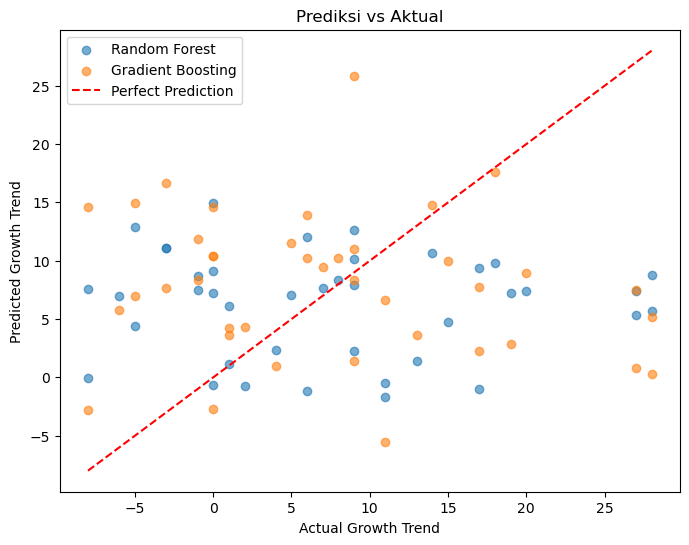

In [34]:
# ==========================
# Baseline & Visualisasi
# ==========================

import matplotlib.pyplot as plt

# Baseline: prediksi rata-rata target
baseline_pred = [df['growth_trend_percent'].mean()] * len(yr_test_inv)
baseline_rmse = mean_squared_error(yr_test_inv, baseline_pred, squared=False)
baseline_r2 = r2_score(yr_test_inv, baseline_pred)

print("\n=== Baseline (Mean Prediction) ===")
print("Baseline RMSE:", baseline_rmse)
print("Baseline R²:", baseline_r2)

# Bandingkan Model vs Baseline
print("\nPerbandingan RMSE:")
print("Baseline:", baseline_rmse)
print("Random Forest:", mean_squared_error(yr_test_inv, yr_pred_inv, squared=False))
print("Gradient Boosting:", mean_squared_error(yr_test_inv, gbr_pred_inv, squared=False))

# ==========================
# Visualisasi Prediksi vs Aktual
# ==========================
plt.figure(figsize=(8,6))
plt.scatter(yr_test_inv, yr_pred_inv, alpha=0.6, label="Random Forest")
plt.scatter(yr_test_inv, gbr_pred_inv, alpha=0.6, label="Gradient Boosting")
plt.plot([yr_test_inv.min(), yr_test_inv.max()],
         [yr_test_inv.min(), yr_test_inv.max()],
         'r--', label="Perfect Prediction")
plt.xlabel("Actual Growth Trend")
plt.ylabel("Predicted Growth Trend")
plt.title("Prediksi vs Aktual")
plt.legend()
plt.show()



=== Korelasi Numerik dengan Target ===
growth_trend_percent         1.000000
salary_per_year_exp          0.063975
avg_salary_million_idr       0.054433
remote_opportunity           0.019268
demand_index                 0.009075
experience_required_years   -0.040966
Name: growth_trend_percent, dtype: float64


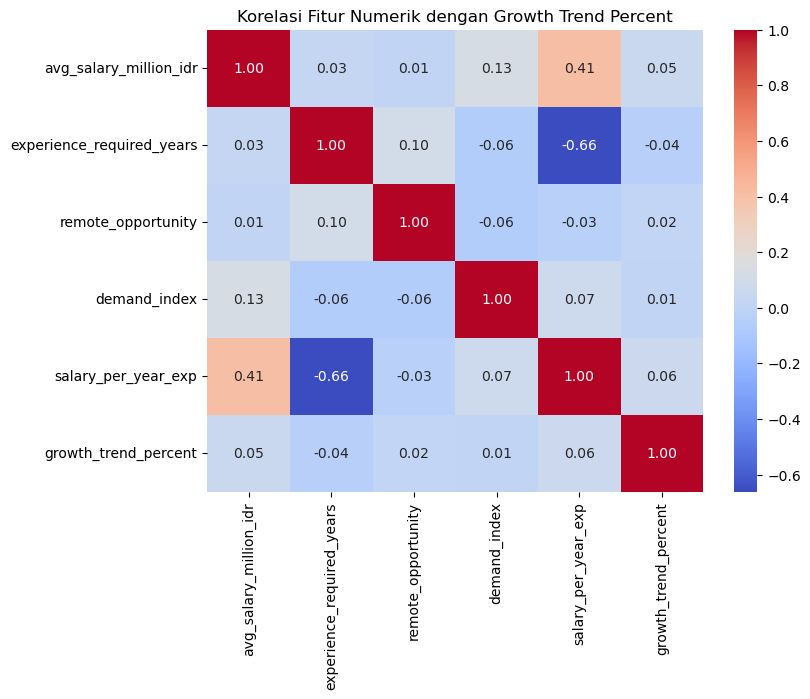

In [35]:
# ==========================
# Analisis Korelasi dengan Target
# ==========================

# Korelasi fitur numerik terhadap growth_trend_percent
corr = df[num_cols + ['growth_trend_percent']].corr()

print("\n=== Korelasi Numerik dengan Target ===")
print(corr['growth_trend_percent'].sort_values(ascending=False))

# Visualisasi heatmap korelasi
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasi Fitur Numerik dengan Growth Trend Percent")
plt.show()



## Kesimpulan & Rekomendasi untuk SmartPath
- Fokuskan kurikulum: top features yang berpengaruh (lihat feature importance). 
- Gunakan segmentasi cluster untuk membuat jalur belajar (Analyst / BI / Engineer). 
- Terapkan monitoring demand_index secara berkala dan gunakan model untuk memprediksi kebutuhan batch.

Notebook ini disertakan bersama Streamlit dashboard untuk presentasi interaktif.
